# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Data loading

In [3]:
df_client = pd.read_csv('client_data.csv')
df_price = pd.read_csv('price_data.csv')

# Data prepocessing

## Feature selection

Berdasarkan analisis pada EDA kita akan menggunakan fitur-fitur berikut:

'channels_sales', 'has_gas', 'origin_up', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_peak', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'pow_max', channel_sales', 'has_gas', 'origin_up'



In [4]:
merged_df = df_price.join(df_client.set_index('id'), on='id', how='inner')
merged_df.shape

(175149, 33)

In [5]:
merged_df["price_date"] = pd.to_datetime(merged_df["price_date"], format='%Y-%m-%d')

## ## Difference between off-peak prices in December and preceding January

In [6]:
monthly_price_by_id = merged_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,00114d74e963e47177db89bc70108537,-0.003994,-0.000001
4,0013f326a839a2f6ad87a1859952d227,-0.006171,0.000000


In [7]:
monthly_price_by_id.head()


,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [8]:
jan_prices.head()


,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-01-01,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-01-01,0.150837,44.444710
3,00114d74e963e47177db89bc70108537,2015-01-01,0.149434,44.266931
4,0013f326a839a2f6ad87a1859952d227,2015-01-01,0.127818,40.728885


In [9]:
merged_df = pd.merge(merged_df, diff, on='id')
merged_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,channel_sales,cons_12m,...,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,foosdfpfkusacimwkcsosbicdxkicaua,3576,...,21.52,21.52,1,52.53,3,ldkssxwpmemidmecebumciepifcamkci,13.2,0,-0.005508,0.177779
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,foosdfpfkusacimwkcsosbicdxkicaua,3576,...,21.52,21.52,1,52.53,3,ldkssxwpmemidmecebumciepifcamkci,13.2,0,-0.005508,0.177779
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,foosdfpfkusacimwkcsosbicdxkicaua,3576,...,21.52,21.52,1,52.53,3,ldkssxwpmemidmecebumciepifcamkci,13.2,0,-0.005508,0.177779
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,foosdfpfkusacimwkcsosbicdxkicaua,3576,...,21.52,21.52,1,52.53,3,ldkssxwpmemidmecebumciepifcamkci,13.2,0,-0.005508,0.177779
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,foosdfpfkusacimwkcsosbicdxkicaua,3576,...,21.52,21.52,1,52.53,3,ldkssxwpmemidmecebumciepifcamkci,13.2,0,-0.005508,0.177779


## Memisihkan antara fitur X dan target y

In [10]:
# splitting X dan y
X = merged_df[['channel_sales', 'has_gas', 'origin_up','cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
        'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_peak',
        'margin_gross_pow_ele', 'margin_net_pow_ele', 'pow_max']]
y = merged_df['churn']  

## Memisahkan antara train dan test set

In [11]:
# Splitting between Train-Set, and Test-Set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
print(X_train.shape)
print(X_test.shape)

(140119, 13)
(35030, 13)


## Handling outliers

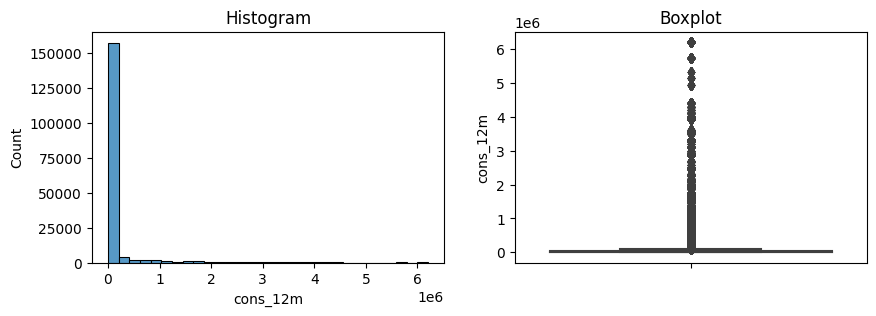

Skewness: 5.99631345062038
The distribution is skewed


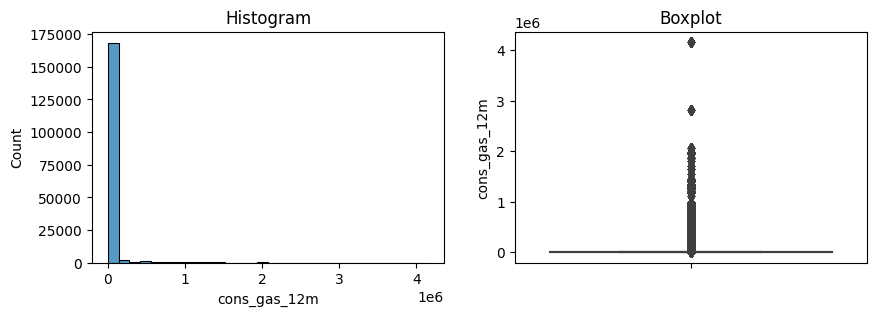

Skewness: 9.60158765821237
The distribution is skewed


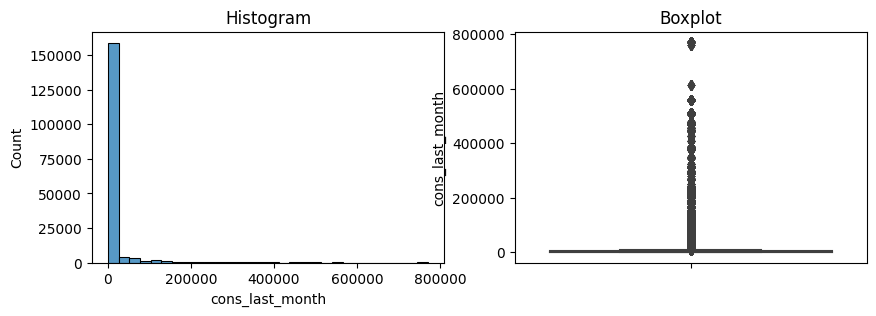

Skewness: 6.389956691973198
The distribution is skewed


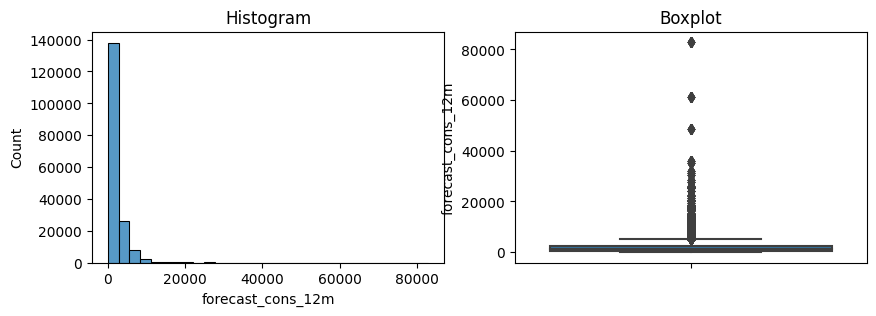

Skewness: 7.15904940696146
The distribution is skewed


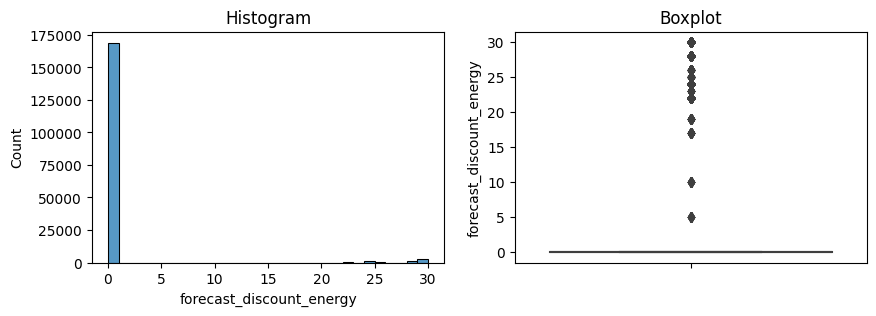

Skewness: 5.153648310541697
The distribution is skewed


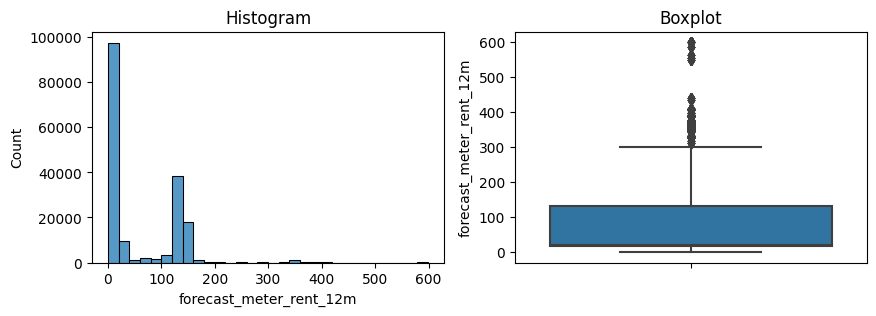

Skewness: 1.5036701850418424
The distribution is skewed


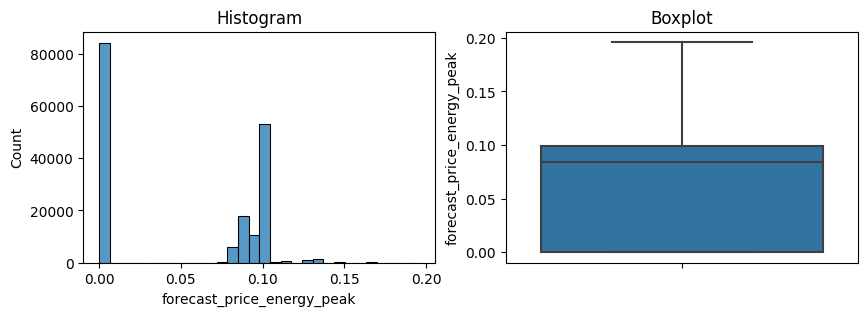

Skewness: -0.01413761762963863
The distribution is normal


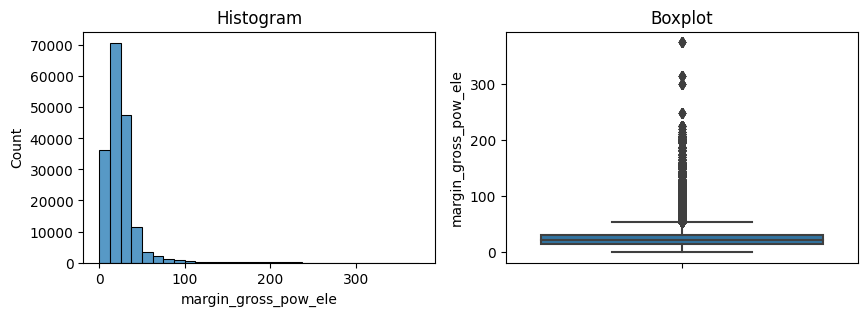

Skewness: 4.472288629474808
The distribution is skewed


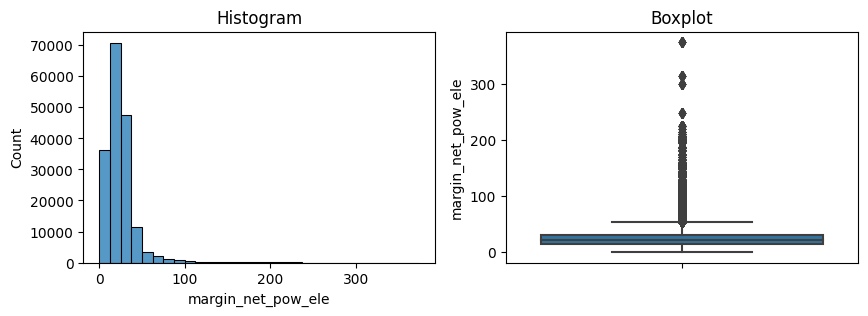

Skewness: 4.472982484799837
The distribution is skewed


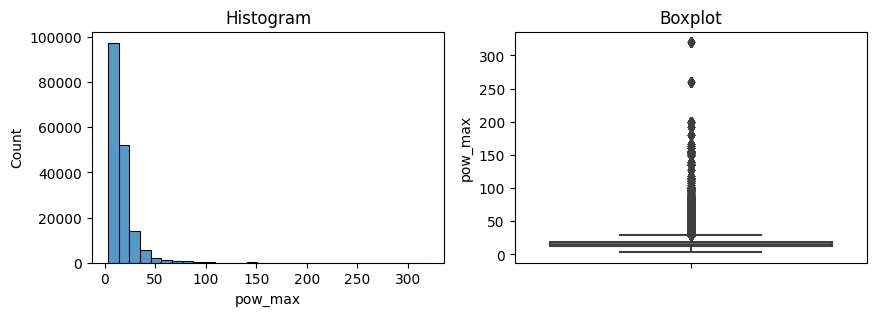

Skewness: 5.7873916658438675
The distribution is skewed


In [12]:
# Cek visualisasi dengan histogram dan boxplot

numeric_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
        'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_peak',
        'margin_gross_pow_ele', 'margin_net_pow_ele', 'pow_max']

# Cek distribusi data dan outliers
def check_distribution_outliers(merged_df, columns):
    for column in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(merged_df[column], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=merged_df[column])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', merged_df[column].skew())
        if (merged_df[column].skew() <= -0.5) or (merged_df[column].skew() >= 0.5):
            print('The distribution is skewed')
        else:
            print('The distribution is normal')

check_distribution_outliers(merged_df[numeric_columns], numeric_columns)

In [13]:
# Fungsi untuk penanganan outlier dengan IQR winsorization
def iqr_winsorize_column(merged_df, column):
    q1 = merged_df[column].quantile(0.25)
    q3 = merged_df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    winsorized = merged_df[column].clip(lower_bound, upper_bound)
    merged_df[column] = winsorized
    return merged_df

# Penanganan outlier dengan IQR winsorization
for feature in numeric_columns:
    merged_df = iqr_winsorize_column(merged_df, feature)

## Feature scaling & encoding

In [14]:
numerical_columns = ['cons_12m', 'cons_gas_12m',
       'cons_last_month', 'forecast_cons_12m', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_peak',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'pow_max']
categorical_columns = ['channel_sales', 'has_gas', 'origin_up']

# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

# Model

In [15]:
from sklearn.ensemble import RandomForestClassifier

# random forest pipeline
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=20))
])

In [16]:
# model training
model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cons_12m', 'cons_gas_12m',
                                                   'cons_last_month',
                                                   'forecast_cons_12m',
                                                   'forecast_discount_energy',
                                                   'forecast_meter_rent_12m',
                                                   'forecast_price_energy_peak',
                                                   'margin_gross_pow_ele',
                                                   'margin_net_pow_ele',
                                                   'pow_max']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['channel_sales', 'has_gas',
                                                   'origin_up'])])),
                ('classifier', RandomForestClassifier(random_state=20))])

In [17]:
# model predict
y_pred_train_rf = model_rf.predict(X_train)
y_pred_test_rf = model_rf.predict(X_test)

In [18]:
# confusion matrix train 
print('Hasil prediksi train-set')
print(confusion_matrix(y_train, y_pred_train_rf))

# confusion matrix test
print('\n Hasil prediksi test-set')
print(confusion_matrix(y_test, y_pred_test_rf))

Hasil prediksi train-set
[[126441      0]
 [     0  13678]]

 Hasil prediksi test-set
[[31705     0]
 [    0  3325]]


In [19]:
# classification report train 
print('Hasil prediksi train-set')
print(classification_report(y_train, y_pred_train_rf))

# classification report test
print('\n Hasil prediksi test-set')
print(classification_report(y_test, y_pred_test_rf))

Hasil prediksi train-set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126441
           1       1.00      1.00      1.00     13678

    accuracy                           1.00    140119
   macro avg       1.00      1.00      1.00    140119
weighted avg       1.00      1.00      1.00    140119


 Hasil prediksi test-set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31705
           1       1.00      1.00      1.00      3325

    accuracy                           1.00     35030
   macro avg       1.00      1.00      1.00     35030
weighted avg       1.00      1.00      1.00     35030



The analysis of the recall results is as follows:

On the train-set, the recall for class 0 and 1 is 1.00, which means the model is capable of accurately identifying all samples that are not churned and those that are churned.

On the test-set, the recall for class 0 and 1 is 1.00, which means the model is capable of accurately identifying all samples that are not churned and those that are churned in the test data.

Thus, this model can be categorized as a good fit.




